## Libraries

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image

c:\Users\El-Wattaneya\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\El-Wattaneya\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Data Preprocessing

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

training_data = datagen.flow_from_directory("training_cats",target_size=(128,128))
test_data = datagen.flow_from_directory("testing_cats",target_size=(128, 128))  

# Concatenates the batches of training and testing data into two separate arrays x_train and x_test
x_train =np.concatenate([training_data.next()[0] for i in range(len(training_data))]) 
x_test = np.concatenate([test_data.next()[0] for i in range(len(test_data))])           


Found 4000 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.


In [3]:
# add random noise "to prevent overfitting"
s = (128,128,3)
mean = 0
var = 0.01
sigma = np.sqrt(var)
noise = np.random.normal(loc = mean, scale= sigma,size=s)
x_train_n = x_train + noise
x_test_n = x_test + noise

## Auto Encoder

In [3]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [4]:
autoEncoder = Model(input_layer, output_layer)
autoEncoder.compile(optimizer='adam', loss='mse')
autoEncoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         1160  

In [5]:
autoEncoder.fit(x_train, x_train,epochs=10,batch_size=32,shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10
125/125 [==============================] - 108s 857ms/step - loss: 0.0491 - val_loss: 0.0163
Epoch 2/10
125/125 [==============================] - 109s 871ms/step - loss: 0.0137 - val_loss: 0.0130
Epoch 3/10
125/125 [==============================] - 111s 886ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 4/10
125/125 [==============================] - 105s 837ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 5/10
125/125 [==============================] - 106s 852ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 6/10
125/125 [==============================] - 105s 838ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 7/10
125/125 [==============================] - 115s 922ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 8/10
125/125 [==============================] - 107s 859ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 9/10
125/125 [==============================] - 113s 907ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 10/10
125/125 [==============================] - 106s 851m

In [ ]:
# encoded_img = Model(inputs=autoEncoder.input, outputs=autoEncoder.get_layer("CODE").output)
# encoded = encoded_img.predict(x_test)
# encoded.shape

In [6]:
encoder_=Model(input_layer,code_layer)
encoded_vector=encoder_.predict(x_test)

input_layer1 = Input(shape=encoded_vector.shape[1:], name="INPUT")
x1 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(input_layer1)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x1)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x1)
x1 = UpSampling2D((2,2))(x1)
output_layer1 = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x1)

decoder_=Model(input_layer1,output_layer1)
decoder_.compile(optimizer= 'adam',loss='binary_crossentropy')

k=0
for i in range(6,14):
    decoder_.weights[k].assign(autoEncoder.weights[i])
    k = k + 1

In [7]:
# s = (128,128,3)
s = encoded_vector.shape[1:]

mean = 0
var = 0.01
sigma = np.sqrt(var)
noise = np.random.normal(loc = mean, scale= sigma,size=s)
encoded_vector_n = encoded_vector + noise


In [8]:
predections = decoder_.predict(encoded_vector_n)
encoded_vector_n.shape

(1011, 16, 16, 8)

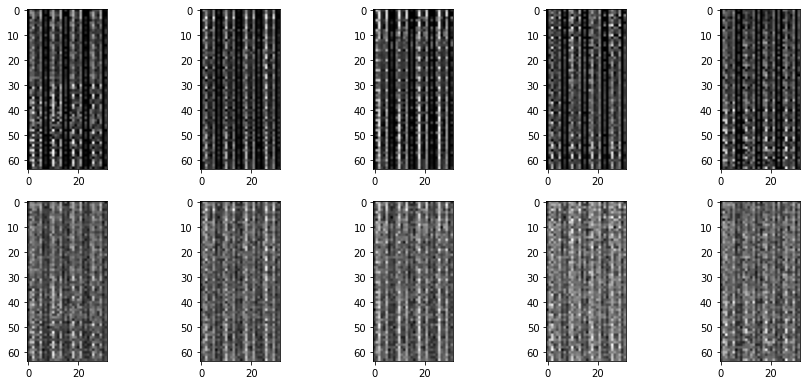

In [9]:
n = 5
plt.figure(figsize=(15,10))

for i in range(n):
    ax = plt.subplot(3,n,i+1)
    plt.imshow(encoded_vector[i].reshape(64,32))
    plt.gray()
    
    ax = plt.subplot(3,n,i+n+1)
    plt.imshow(encoded_vector_n[i].reshape(64,32))
    plt.gray()
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


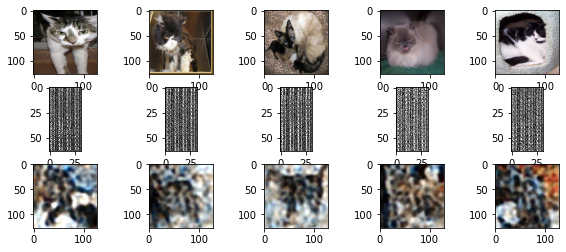

In [10]:
n = 5
plt.figure(figsize=(10,4))

for i in range(n):
    ax = plt.subplot(3,n,i+1)
    plt.imshow(x_train[i].reshape(128,128,3))
    plt.gray()
    
    ax = plt.subplot(3,n,i+n+1)
    plt.imshow(encoded_vector_n[i].reshape(64,32))
    plt.gray()

    ax = plt.subplot(3 , n , i+1+2*n)
    plt.imshow(predections[i].reshape(128,128,3))
    plt.gray()
    
plt.show()